# A Principled Bayesian Inference of a Fluorescence Calibration Factor

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [13]:
import sys
sys.path.insert(0, '../../../')
import numpy as np
import pandas as pd
import pystan 
import mwc.viz
import mwc.stats
import mwc.bayes
import scipy.stats
import matplotlib.pyplot as plt
import mwc.viz
import tqdm
seed = np.random.seed(666)
colors = mwc.viz.personal_style()
# import altair as alt
# alt.data_transformers.enable('json')
%load_ext stanmagic

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


In this notebook, we lay out a principled workflow for the parameter estimation of a fluorescence calibration factor. This notebook covers the inference of the calibratoin factor from a single measurement. A principled analysis of a hierarchical approach will be written at a later date. 

## Writing A Physical Model

It has become trivial in the era of molecular biology to label your favorite protein with a reporter that fluoresces at your favorite wavelength. Similarly, single-cell and single-molecule microscopy has become commonplace, making precise measurement of total cell fluorescence and/or localization a relatively painless procedure. However, it is still remarkably difficult to translate that precise measurement of fluorescence into the absolute copy number of your protein. 

By measuring the fluctuations in intensity between a mother/daughter pair after cell division, we can back calculate how bright a single molecule of interest is in arbitrary unitls, permitting the relatively easy calculation of protein copy number. We operate under the assumption that protein degradation is negligible and that protein production is ceased immediately before division. Using these assumptions, we can say that the total intensity of a given cell $I_\text{tot}$ is related to the number of fluorescent proteins and their relative brightness,

$$
I_\text{tot} = \alpha N_\text{tot}, \tag{1}
$$

where $N_\text{tot}$ is the total number of proteins and $\alpha$ is the brightness of a single fluorophore. Assuming there is no more production or deradation, we can relate the intensity of the mother cell to the daughter cells by dictating that the fluorescence must be conserved,

$$
I_\text{tot} = I_1 + I_2 = \alpha (N_1 + N_2), \tag{2}
$$

where we have used $I_1$ and $I_2$ to represent the total intensity of daughter cells 1 and 2. By looking at the fluctuations in intensity between the two daughter cells, followed by invocation of the mean and variance of the Binomial distribution, we arrive at the simple relation that

$$
\langle (I_1 - I_2)^2 \rangle = \alpha I_\text{tot}. \tag{3}
$$

Of course, lumped in with $\alpha$ is all of the features of the detector, fluorophore quantum efficiency, and other minutae of measurement. While incorporating these details into the generative model building is the proper thing to do, I know from experience in these experiments and quantitative biological. microscopy in general that the noise in these measurements is much smaller than the noise of the biological system. To this end, we will neglect them for simplicity. 

## Building a Generative Statistical Model

The posterior probability distribution for our parameter of interest $\alpha$ is given by Bayes' theorem as

$$
g(\alpha\,\vert\,[I_1, I_2]) \propto f([I_1, I_2]\,\vert\, \alpha)g(\alpha)
\tag{4},
$$

where I have used $g$ and $f$ to denote probability density functions over parameters and data, respectively. As $I_1$ and $I_2$ are related to each other (through Eq. 2), the likelihood $f([I_1, I_2]\,\vert\, \alpha)$ can be rewritten in the form,

$$
f([I_1, I_2]\,\vert\,\alpha) = f([I_1]\,\vert\, \alpha, [I_2]).\tag{5}
$$

Ultimately, we would like to translate the observed intensity into the nubmer of fluorescent proteins in the cell. Using Eq. 1 and the change-of-variables formula, Eq. 5 can be written in terms of $N_1$ as

$$
f([I_1]\,\vert\, \alpha, [I_2]) = f([N_1]\,\vert\,\alpha, [I_2]) {d N_1 \over d I_1} = {1 \over \alpha^k}f([N_1]\,\vert\,\alpha,[I_2]),\tag{6}
$$

where $k$ is the number of observed division events in the set of observed intensities $[I_1, I_2]$. 

The number of proteins present in the arbitrarily chosen daughter cell 1 ($N_1$) should be binomial distributed with $N_{tot}$ proteins in the mother cell. As such, the functional form of our likelihood can be written as

$$
f([N_1]\,\vert\,\alpha,[I_2]) = {1 \over \alpha^k}\prod\limits_{i=1}^k {\Gamma\left({I_{1,i} + I_{2,i} \over \alpha} + 1\right) \over \Gamma\left({I_1 \over \alpha} + 1\right) \Gamma\left({I_2 \over \alpha} + 1\right)} 2^{-{I_1 + I_2 \over \alpha}},\tag{7}
$$

where Gamma functions are used to avoid factorials of continuous variables. Note here we have used the simplifying assumption that the proteins are partitioned between the two proteins with an equal probability, $p = 1/2$. This is a fair approximation as the repressors to which the fluorescent proteins are covalently bound are always bound to the DNA and therefore are partitioned via segregation of the chromosomes. 


With the likelihood in hand, we are now assigned the task of setting a prior for $\alpha$, which will be verified by prior predictive checks. This is certainly not an obvious endeavor as we do not have a good intuitoin for how bright a single fluorophore should be. However, we do know some limits. For example, it is not possible for the fluoropohore to have a negative value as the detector returns unsigned integeters per pixel as the readout. We also know that our resolution is diffraction limited meaning in the extreme case in which the repressors are frozen in a specific point, their fluorescence will be detected across several pixels. In our system, the interpixel distance of the camera is on the order of 50 nm / pixel meaning that a single fluorophore will have a diameter of 4 - 5 pixels (assuming the extreme scenario in which diffusion of the fluorophore is much slower than the frame rate of our camera). With a bit-depth of 12, the maximum value that a pixel can be assigned is $2^{12} - 1 = 4095$ arbitrary units. Thus, the maximum brightness of a single fluorophore that can be detected on our system is $ 4 \times 4095 \approx 1.5\times 10^4$ a.u. /molecule. This, of course is a large upper bound and in our system the fluorescence will be below this value. However, we can use these bounds to  define a prior. As flat priors are difficult to sample and a uniform prior is not appropriate, we can assign a log-normal prior centered at $\approx 5$ (~200 [a.u.]) with a scale parameter of 3.

## Prior Predictive Checks
The best way to check if this choice of prior is reasonable is to draw $N$ values from this prior distribution and use $\alpha$ to generate a data set of $M$ values for $I_1$ based on a set of $M$ protein copy numbers. To start, we will define a set protein copy numbers $N_1$ that cover physiologically reasonable values of intenisities.

In [17]:
# Define the set of copy numbers. 
M = 500
N1 = np.random.gamma(10, 10, M).astype(int) # Gamma distributed to mimic bursty gene expression

We can now make $N$ draws out of the prior distribution for $\alpha$ and compute the observed intensities $I_1$. We'll make this as a data frame for use later. 

In [18]:
# Make N draws out of a lognormal distribution for alpha. 
N = 800
alpha_draws = np.random.lognormal(5, 3, N)

# Compute the intensities. 
n, a = np.meshgrid(N1, alpha_draws)
I1 = n * a

# Make the dataframe. 
ppc_df = pd.DataFrame(np.array([I1.flatten(), n.flatten(), a. flatten()]).T, 
                     columns=['I1', 'N1', 'alpha_true'])

We can now plot the ECDF of each data set and see how they are distributed.

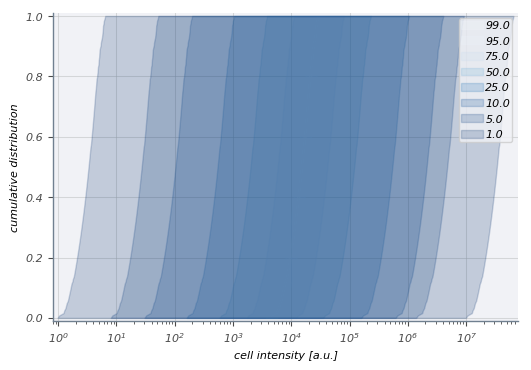

In [19]:
# Compute percentiles of the data.
percentiles = [0.99, 0.95, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]
cmap = plt.cm.Blues_r(percentiles)
percentile_df = pd.DataFrame([])
for g, d in ppc_df.groupby(['N1']):
    for i, p in enumerate(percentiles):
        lower, upper = np.percentile(d['I1'], (50 * p, (100 - ((100 * p)/2))))
        percentile_df= percentile_df.append({'N1': g,
                                        'lower': lower,
                                        'upper': upper,
                                        'percentile': p}, ignore_index=True)
        
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i, p in enumerate(percentiles):
    d = percentile_df[percentile_df['percentile']==p]
    y = np.linspace(0, 1, len(d))
    min_sorted = np.sort(d['lower'])
    max_sorted = np.sort(d['upper'])
    ax.fill_betweenx(y, min_sorted, max_sorted, color=cmap[i], label=p*100, alpha=0.2)
    
ax.set_xscale('log')
ax.set_xlabel('cell intensity [a.u.]')
ax.set_ylabel('cumulative distribution')
ax.legend()   

These distributions look pretty good -- most of the generated intensities are between $10^2$ and $10^7$ a.u. per cell which is in line with what I would see in the extremes of my experiments. There s also barely any density below $1$ a.u. / cell, which is what we would want to see during the prior predictive checks. 

Satisfied with our choice of prior, we can now define the model using Stan, as given in the cell below. 

In [10]:
%%stan -v hier
functions{
    /** 
    * Approximate the Binomial distirubution for continuous variables 
    * as a ratio of Gamma functions 
    * 
    * @param I1: Observed fluorescence of daughter cell 1. 
    * @param I2: Observed fluorescence of daughter cell 2.
    * @param alpha: Fluorescenc calibration factor in units of a.u. / molecule
    * @param N: Total number of measurements 
    **/
    real GammaApproxBinom_lpdf(vector I1, vector I2, real alpha) {
        return sum(-log(alpha) + lgamma(((I1 + I2) ./ alpha) + 1) - lgamma((I1 ./ alpha) + 1) - lgamma((I2 ./ alpha) + 1) - ((I1 + I2) ./ alpha) * log(2));
    } 

}
     
data {
    int<lower=0> N; // Number of data points
    vector<lower=0>[N] I1; // Observed fluorescence of daughter cell 1
    vector<lower=0>[N] I2; // Observed fluorescence of daughter cell 2
}

parameters {
    real<lower=0> alpha;
}

model {     
    alpha ~ lognormal(5, 3);
    I1 ~ GammaApproxBinom(I2, alpha);  
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in hier object.
Type hier in a cell to see a nicely formatted code output in a notebook
     ^^^^
Access model compile output properties
hier.model_file -> Name of stan_file [None]
hier.model_name -> Name of stan model [None]
hier.model_code -> Model code [functions{     /**   ....]


In [11]:
# Compile the model 
model = pystan.StanModel(model_code=hier.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8559b9db0f703ee877aa47b3cbc59b24 NOW.


## Computational Tractability

Our next step in the workflow is to ensure that our model is well specified and computationally accessible. To do so, we perform [Simulation Based Calibration]() as put forward by Talts. et al. in 2018. To do so, given the draws from the prior, we generate $M$ simulated data sets for the partitioning with $N$ divisions each, where the intensity is dicted by the draw from the $\alpha$ prior distribution. Using this data set, we then perform inference on these data and compare the data-averaged posterior distribution for $\alpha$ to the true prior distribution. If everything works as expected, we should recover the prior distribution and have uniformly distributed rank statistics. In addition, we can check the degree to which the prior distribution shrinks (shrinkage) as well as the $z-$score, which quantifies how accurately the posterior captures the model configuration.

To permit direct comparison between inferential runs, we will use the same randomly generated protein copy numbers and only change the measured intensity $I$. 

In [24]:
# Define the number of divisions
n_tot = np.random.gamma(10, 10, M).astype(int)
n1 = np.random.binomial(n_tot, p=0.5)
n2 = n_tot - n1

# Set up a dataframe for the storage of the inference results
sbc_df = pd.DataFrame([], columns=['alpha_true', 'mean_alpha', 'z_score', 'shrinkage']) 

# Perform SBC
for i, alpha in enumerate(tqdm.tqdm(alpha_draws)):
    # Compute intensities
    I1 = n1 * alpha
    I2 = n2 * alpha
    
    # Perform inference. 
    samples = model.sampling(dict(N=M, I1=I1, I2=I2))
    samples = samples.to_dataframe()
    
    # Compute the statistics. 
    mean_alpha = np.mean(samples['alpha'])
    shrinkage = 1 - (np.var(samples['alpha']) / np.var(alpha_draws))
    z_score = np.abs((mean_alpha - alpha) / np.var(samples['alpha']))
    
    # Save to the data frame. 
    sbc_df = sbc_df.append(dict(alpha_true=alpha, mean_alpha=mean_alpha,
                               z_score=z_score, shrinkage=shrinkage), ignore_index=True)    
    
# Compute the rank statistic. 
sbc_df['rank_statistic'] = np.array([np.sum(sbc_df['mean_alpha'] <= a) for a in alpha_draws])

 40%|████      | 321/800 [26:39<39:38,  4.97s/it]Process ForkPoolWorker-2725:
Process ForkPoolWorker-2726:
Process ForkPoolWorker-2724:
Process ForkPoolWorker-2727:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/gchure/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/gchure/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/gchure/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/gchure/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/gchure/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/gchure/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(

KeyboardInterrupt: 

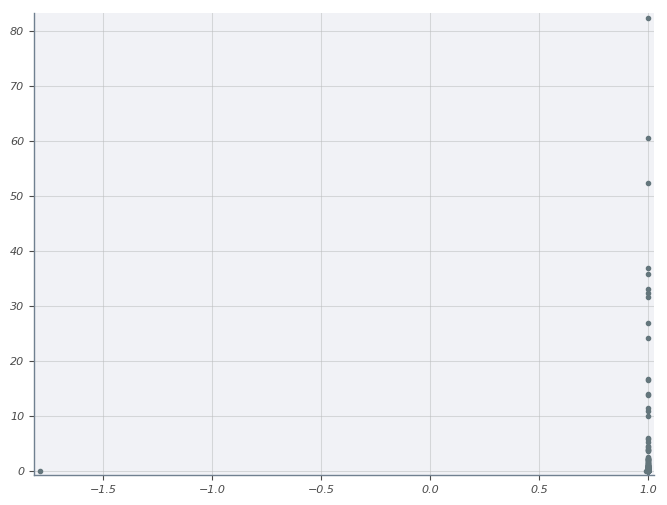

In [26]:
plt.plot(sbc_df['shrinkage'], sbc_df['z_score'], '.')

In [7]:
%%stan -v hier
functions{
    /** 
    * Approximate the Binomial distirubution for continuous variables 
    * as a ratio of Gamma functions 
    * 
    * @param I1: Observed fluorescence of daughter cell 1. 
    * @param I2: Observed fluorescence of daughter cell 2.
    * @param alpha: Fluorescenc calibration factor in units of a.u. / molecule
    * @param N: Total number of measurements 
    **/
    real GammaApproxBinom_lpdf(vector I1, vector I2, real alpha) {
        return sum(-log(alpha) + lgamma(((I1 + I2) ./ alpha) + 1) - lgamma((I1 ./ alpha) + 1) - lgamma((I2 ./ alpha) + 1) - ((I1 + I2) ./ alpha) * log(2));
    } 

}
     
data {
    int<lower=0> N; // Number of data points
    vector<lower=0>[N] I1; // Observed fluorescence of daughter cell 1
    vector<lower=0>[N] I2; // Observed fluorescence of daughter cell 2
}

parameters {
    // Generate non-centered modifiers
    real<lower=0> alpha_mu;
    real alpha_raw; 
    real<lower=0> tau;
}

transformed parameters{
    real alpha = alpha_mu + tau * alpha_raw;
}


model {    
    alpha_raw ~ normal(0, 2);
    alpha_mu ~ lognormal(2, 2);
    tau ~ normal(0, 1);
    I1 ~ GammaApproxBinom(I2, alpha);  
}


Using pystan.stanc compiler..
Failed to parse Stan model 'anon_model_4ef06f7f06edfad400f84734048ad16f'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

No matches for: 

  lgamma_rng(vector)

Function lgamma_rng not found.
  error in 'anon_6b1ab98c-fcd5-4b85-b62d-bf6aea75b94d.stan' at line 15, column 70
  -------------------------------------------------
    13:     } 
    14:     real GammaApproxBinom_rng(vector I1, vector I2, real alpha) {
    15:         return exp(-log(alpha) + lgamma_rng(((I1 + I2) ./ alpha) + 1) - lgamma_rng((I1 ./ alpha) + 1) - lgamma_rng((I2 ./ alpha) + 1) - ((I1 + I2) ./ alpha) * log(2));
                                                                             ^
    16:     } 
  -------------------------------------------------




In [36]:
model = pystan.StanModel(model_code=hier.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8279ca5d8b472d53461b0ef41ed5fb07 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpcrh9exh8/stanfit4anon_model_8279ca5d8b472d53461b0ef41ed5fb07_8943798297178481699.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [37]:
data_dict = {'N': len(df), 'I1':df['I1'], 'I2':df['I2']};
samples = model.sampling(data_dict, iter=1000)

In [38]:
samples

Inference for Stan model: anon_model_8279ca5d8b472d53461b0ef41ed5fb07.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha_mu  141.52    0.28   9.34 123.24  135.4 141.35 147.46 160.41   1121    1.0
alpha_raw   0.08    0.05   1.98  -3.65  -1.29   0.06   1.39   4.11   1406    1.0
tau         0.82    0.02   0.59   0.04   0.35   0.71   1.17   2.24   1502    1.0
alpha     141.59    0.26   9.17 123.83 135.35 141.43 147.41 159.95   1227    1.0
lp__       -3990    0.05   1.31  -3993  -3990  -3989  -3989  -3988    650    1.0

Samples were drawn using NUTS at Fri Feb 15 16:15:28 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).